# Project 1g: using real-world geographic data

In [30]:
import numpy as np
from imageio.v3 import imread
import matplotlib.pyplot as plt
# from matplotlib import cm
import numpy as np

from scipy.stats import normaltest

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

In [2]:
# Loading the terrain data
terrain1 = imread('SRTM_data_Norway_1.tif')
terrain2 = imread('SRTM_data_Norway_2.tif')
print(type(terrain1), terrain1.shape, terrain2.shape)

<class 'numpy.ndarray'> (3601, 1801) (3601, 1801)


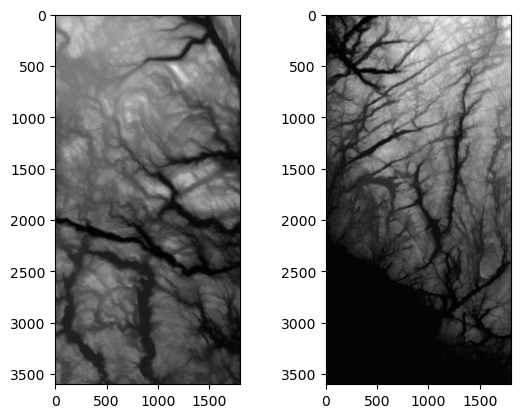

In [3]:
# Plotting the terrains
fig, ax = plt.subplots(ncols=2)
ax[0].imshow(terrain1, cmap="gray")
ax[1].imshow(terrain2, cmap="gray")
plt.show()

In [54]:
# Splitting the data from terrain1 into train / test
index_vals = np.array(range(np.prod(terrain1.shape)))
print(index_vals.shape)

terrain1_values = terrain1.flatten()

idx_train, idx_test = train_test_split(index_vals, test_size=.20, random_state=42)
print(idx_train.shape, idx_test.shape, round(idx_train.shape[0] / idx_test.shape[0], 2))

values_train_raw = terrain1_values[idx_train].reshape(-1, 1)
values_test_raw = terrain1_values[idx_test].reshape(-1, 1)

# Coordinate values (x and y coordinates, NOT as model variables!)
x_train = idx_train % terrain1.shape[0]
y_train = idx_train // terrain1.shape[0]
x_test = idx_test % terrain1.shape[0]
y_test = idx_test // terrain1.shape[0]

(6485401,)
(5188320,) (1297081,) 4.0


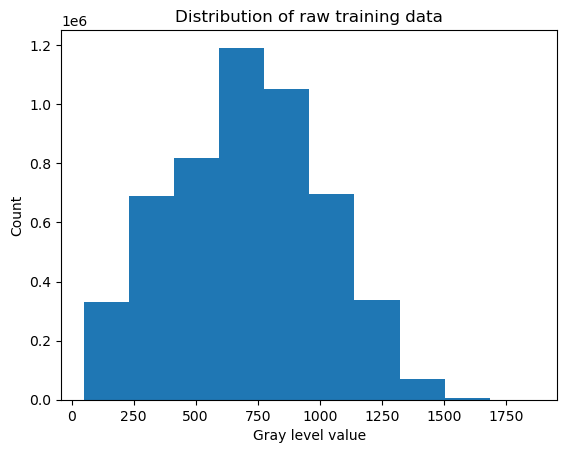

NormaltestResult(statistic=array([194304.81035592]), pvalue=array([0.]))


In [55]:
# Looking at the shape of the training data, to decide how to scale the data
# The test data should not be used for this to avoid data leakage (as the decision process is a form of learning, even though its human and not machine!)
fig = plt.subplots()
plt.hist(values_train_raw.ravel())
plt.xlabel("Gray level value")
plt.ylabel("Count")
plt.title("Distribution of raw training data")
plt.show()

print(normaltest(values_train_raw))

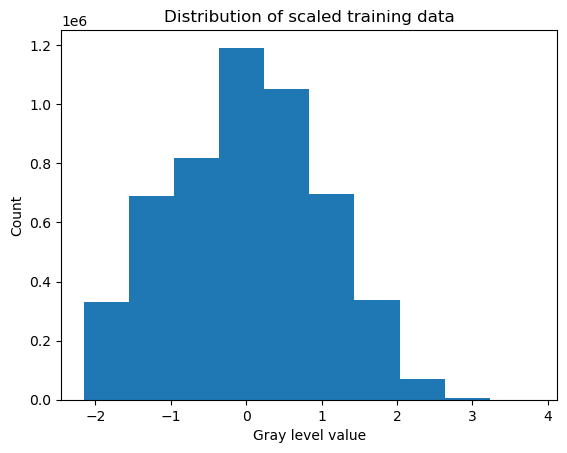

In [56]:
# The data seems to follow a normal distrubtion, therefore using standard scaling / z-score normalizing
# which centers the data to zero and scales to a standard deviation of 1
scaler_image = StandardScaler()
values_train = scaler_image.fit_transform(values_train_raw) # Only fit to training data
values_test = scaler_image.transform(values_test_raw)

fig = plt.subplots()
plt.hist(values_train.ravel())
plt.xlabel("Gray level value")
plt.ylabel("Count")
plt.title("Distribution of scaled training data")
plt.show()

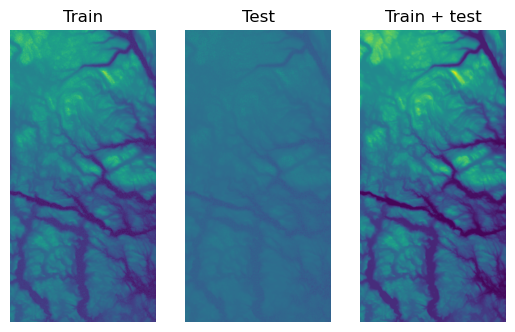

In [57]:
# Validating the train / test split visually by plotting images separately and combined
img_train = np.empty(shape=len(index_vals))
img_test = np.empty(shape=len(index_vals))

img_train[idx_train] = values_train.ravel()
img_test[idx_test] = values_test.ravel()

img_train = img_train.reshape(terrain1.shape)
img_test = img_test.reshape(terrain1.shape)

fig, ax = plt.subplots(ncols=3)
ax[0].imshow(img_train)
ax[0].set_title("Train")
ax[1].imshow(img_test)
ax[1].set_title("Test")
ax[2].imshow(img_train + img_test)
ax[2].set_title("Train + test")
[axi.axis("off") for axi in ax]

plt.show()

In [66]:
# Calculating and normalizing x and y - values,
# using a min-max scaler as each pair of values appear only once - i.e. are uniformly distributed
scaler_x = MinMaxScaler(feature_range=(-1, 1))
scaler_y = MinMaxScaler(feature_range=(-1, 1))

x_train = scaler_x.fit_transform(x_train.reshape(-1, 1)).reshape(-1)
x_test = scaler_x.transform(x_test.reshape(-1, 1)).reshape(-1)
y_train = scaler_y.fit_transform(y_train.reshape(-1, 1)).reshape(-1)
y_test = scaler_y.transform(y_test.reshape(-1, 1)).reshape(-1)

print(x_train.shape, y_train.shape)

(5188320,) (5188320,)


### OLS
Creating the design matrix $X$ with $x$ and $y$ as features up until degree $p$

In [68]:
# Creating design matrix X
# no intercept needed as image gray level data are centered on zero

def create_2d_polynomial_design_matrix(x, y, pmax=5, include_interactions=False):
    # Create design matrix for polynomial up to degree 5, using both x and y as predictors, as [x, y, x^2, y^2, xy, ....]
    # TODO: include interaction terms xy, x^2y, xy^2, etc...
    N = len(x)
    M = 1 + 2 * pmax
    X = np.empty(shape=(N, M))
    m = 0

    for p in range(pmax + 1):
        if p == 0:
            X[:, m] = np.ones(N)    # only need one rows for intercept
            m += 1
        else:
            X[:, m] = x**p
            X[:, m + 1] = y**p
            m += 2
    # print(f"Design matrix of polynomial up to degree {pmax} created:", X.shape)

    return X

# Big X = design matrix
X_train = create_2d_polynomial_design_matrix(x_train, y_train, pmax=1)
X_test = create_2d_polynomial_design_matrix(x_test, y_test, pmax=1)

print(idx_train.shape, idx_test.shape)
print(X_train.shape, X_test.shape)

(5188320,) (1297081,)
(5188320, 3) (1297081, 3)
